In [1]:
!pip install -q transformers datasets torch torchvision albumentations matplotlib load_dotenv
!pip install -q -U "huggingface_hub[cli]"


In [2]:
from dotenv import load_dotenv
import os
# Load environment variables from a file named '.env' in the same directory
load_dotenv()

HUGGINGFACE_TOKEN = os.environ['HUGGINGFACE_TOKEN']
!huggingface-cli login --token $HUGGINGFACE_TOKEN --add-to-git-credential


Token is valid (permission: write).
Cannot authenticate through git-credential as no helper is defined on your machine.
You might have to re-authenticate when pushing to the Hugging Face Hub.
Run the following command in your terminal in case you want to set the 'store' credential helper as default.

git config --global credential.helper store

Read https://git-scm.com/book/en/v2/Git-Tools-Credential-Storage for more details.
Token has not been saved to git credential helper.
Your token has been saved to /root/.cache/huggingface/token
Login successful


In [2]:
# !huggingface-cli download doc2txt/tbl-unet --local-dir tbl-unet

Consider using `hf_transfer` for faster downloads. This solution comes with some limitations. See https://huggingface.co/docs/huggingface_hub/hf_transfer for more details.
Fetching 3 files: 100%|███████████████████████████| 3/3 [00:00<00:00, 11.71it/s]
/root/tstSegFormer/tbl-unet


# init

In [1]:
import torch
import albumentations as A
from albumentations.pytorch import ToTensorV2
import os
import torch.nn as nn
import torchvision
import os
from PIL import Image
import numpy as np
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
from matplotlib import pyplot as plt
import torchvision.transforms.functional as TF
import torch.optim as optim
from tqdm import tqdm
import time

BASE_PATH = "../pdfBLines/tblDS/"
# BASE_PATH = "/home/ubuntu/work/carvana/dataset/"
CHECKPOINT_PATH = "./tbl-unet/tblSrc.pth.tar"


# Hyperparameters etc.
LEARNING_RATE = 1e-5
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
# print("DEVICE", DEVICE)
BATCH_SIZE = 8
NUM_EPOCHS = 100
NUM_WORKERS = 2
IMAGE_HEIGHT = 512 
IMAGE_WIDTH = 512  
PIN_MEMORY = True
LOAD_MODEL = False



/Users/eliaweiss/opt/anaconda3/envs/LayoutLMv3/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# Dataset

In [13]:

class TblDataset(Dataset):
    def __init__(self, root_dir, transform=None):     
        self.root_dir = root_dir
        self.transform = transform
        
        self.images = os.listdir(self.root_dir)    
        self.images = list(filter(lambda x: "_src.jpg" in x, self.images))
        
    def __len__(self):
        return len(self.images)
    
    def __getitem__(self, index):
        img_path = os.path.join(self.root_dir, self.images[index])
        mask_path = os.path.join(self.root_dir, self.images[index].replace("_src.jpg", "_mask.png"))
        image = Image.open(img_path).convert("L")
        mask = Image.open(mask_path).convert("L")
        image = image.resize(mask.size)
        # mask = mask.resize(image.size)
        image = np.array(image, dtype=np.float32)
        mask = np.array(mask, dtype=np.float32)
        mask[mask != 255] = 0
        mask[mask == 255] = 1.0
        
        image1,mask1 = image,mask
        if self.transform is not None:
            augmentations = self.transform(image=image,mask=mask)
            image1 = augmentations['image']
            # assert image1.shape == image.shape, f"{ image1.shape},  {image.shape}"
            mask1 = augmentations['mask']
        
            
        return image1,mask1
    
root_dir=os.path.join(BASE_PATH,"train")
images = os.listdir(root_dir)   
images1 = list(filter(lambda x: "_src.jpg" in x, images))
len(images1)        

1114

In [14]:
train_transform = A.Compose(
    [
        A. Resize(height=IMAGE_HEIGHT, width=IMAGE_WIDTH),
        A. Rotate(limit=2.5, p=0.5),
        A.HorizontalFlip(p=0.5),
        ToTensorV2(),
    ],
)
val_transform = A.Compose(
    [
        A.Resize(height=IMAGE_HEIGHT, width=IMAGE_WIDTH),
        ToTensorV2(),
    ],
)


In [15]:
UnetDataset = TblDataset
train_ds = UnetDataset(
    root_dir=os.path.join(BASE_PATH,"train"),
    transform=train_transform,
)
print(os.path.join(BASE_PATH,"train"))
train_loaders = DataLoader(
    train_ds,
    batch_size=BATCH_SIZE,
    num_workers=NUM_WORKERS,
    pin_memory=PIN_MEMORY,
    shuffle=True,
)
print(len(train_ds))
# val_ds = UnetDataset(
#     root_dir=os.path.join(BASE_PATH,"valid"),

#     transform=val_transform,
# )
# val_loaders = DataLoader(
#     val_ds,
#     batch_size=BATCH_SIZE,
#     num_workers=NUM_WORKERS,
#     pin_memory=PIN_MEMORY,
#     shuffle=False,
# )
for batch in train_loaders:
    images, masks = batch
    break
print("images.shape", images.shape)
print("masks.shape", masks.shape)
data, targets = next(iter(train_loaders))
print ("data.dtype", data.dtype)
print ("targets.dtype", targets.dtype)

../pdfBLines/tblDS/train
1114
images.shape torch.Size([8, 1, 512, 512])
masks.shape torch.Size([8, 512, 512])
data.dtype torch.float32
targets.dtype torch.float32


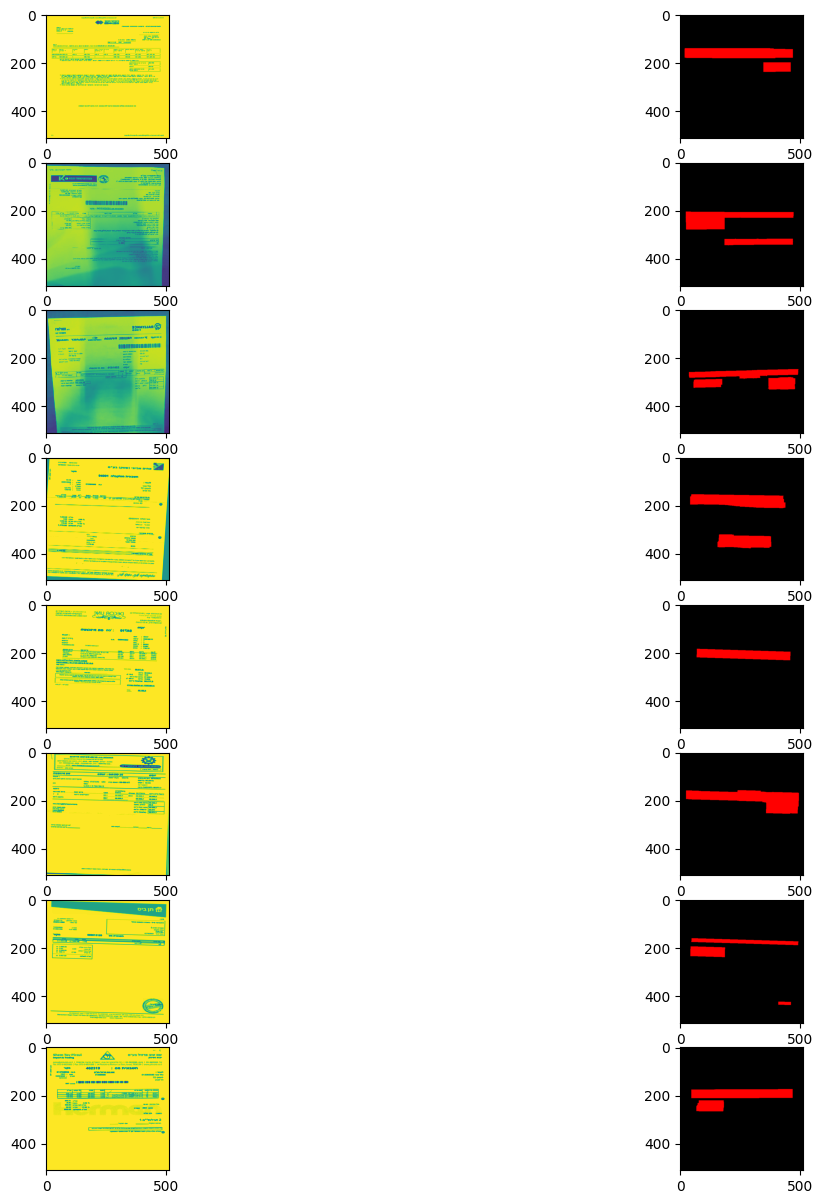

In [16]:
color_map = {
    0:(0,0,0),
    1:(255,0,0),
}

def prediction_to_vis(prediction):
    vis_shape = prediction.shape + (3,)
    vis = np.zeros(vis_shape)
    for i,c in color_map.items():
        vis[prediction == i] = color_map[i]
    return Image.fromarray(vis.astype(np.uint8))

for batch in train_loaders:
    images, masks = batch
    break

n_plots = BATCH_SIZE
f, axarr = plt.subplots(n_plots,2)
f.set_figheight(15)
f.set_figwidth(15)

for i in range(n_plots):
    image =images[i,:,:].permute(1, 2, 0)
    axarr[i,0].imshow(image)
    axarr[i,1].imshow(prediction_to_vis(masks[i,:,:]))

# Unet model

In [18]:

class DoubleConv(nn.Module):
    def __init__(self, in_channels, out_channels) -> None:
        super(DoubleConv, self).__init__()
        self.conv = nn.Sequential(
            # kernel, stride, padding - same convolution
            nn.Conv2d(in_channels, out_channels, 3, 1, 1, bias=False),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),
            # kernel, stride, padding - same convolution
            nn.Conv2d(out_channels, out_channels, 3, 1, 1, bias=False),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),
        )

    def forward(self, x):
        return self.conv(x)


class UNET(nn.Module):
    def __init__(self,
                 in_channels=3, out_channels=1,
                 features=[64, 128, 256, 512]
                 ) -> None:
        super(UNET, self).__init__()
        self.downs = nn.ModuleList()
        self.ups = nn.ModuleList()

        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)

        # Down part
        for feature in features:
            self.downs.append(DoubleConv(in_channels, feature))
            in_channels = feature

        # Up part
        for feature in reversed(features):
            self.ups.append(
                nn.ConvTranspose2d(feature*2, feature, kernel_size=2, stride=2)
            )
            self.ups.append(DoubleConv(feature*2, feature))

        self.bottleneck = DoubleConv(features[-1], features[-1]*2)

        self.final_conv = nn.Conv2d(features[0], out_channels, kernel_size=1)

    def forward(self, x):
        # print("Forward","x.dtype",x.dtype)
        skip_connections = []
        for down in self.downs:
            x = down(x)
            skip_connections.append(x)
            x = self.pool(x)

        x = self.bottleneck(x)

        skip_connections = skip_connections[::-1]

        for idx in range(0, len(self.ups), 2):
            x = self.ups[idx](x)
            skip_connection = skip_connections[idx//2]

            if x.shape != skip_connection.shape:
                x = TF.resize(x, size=skip_connection.shape[2:])

            concat_skip = torch.cat((skip_connection, x), dim=1)
            x = self.ups[idx+1](concat_skip)

        return self.final_conv(x)


def test():
    x = torch.randn((3, 1, 161, 161))
    model = UNET(in_channels=1, out_channels=1)
    pred = model(x)
    print(pred.shape)
    print(x.shape)
    assert pred.shape == x.shape


# test()

# Utils

In [19]:
def load_checkpoint(checkpoint, model):
    print("=> Loading checkpoint")
    model.load_state_dict(checkpoint["state_dict"])

def save_checkpoint(state, filename="my_checkpoint.pth.tar"):
    print("=> Saving checkpoint",filename)
    torch.save(state, filename)

def check_accuracy(loader, model, device="cuda"):
    print("Checking accuracy")
    num_correct = 0
    num_pixels = 0
    dice_score = 0
    model.eval()

    with torch.no_grad():
        for idx, (x, y) in enumerate(loader):
            x = x.to(device)
            y = y.to(device).unsqueeze(1)
            preds = torch.sigmoid(model(x))
            preds = (preds > 0.5).float()
            
            acc = (preds == y).sum()
            numElem = torch.numel(preds)
            # print(idx, acc/numElem)
            
            num_correct += acc
            num_pixels += numElem
            dice_score += (2*(preds*y).sum())/(
                (preds+y).sum() + 1e-8
            )

        print(
            f"Got {num_correct}/{num_pixels} with acc {num_correct/num_pixels*100:.2f}"
        )

        dice = dice_score/len(loader)
        print(f"Dice score: {dice}")

        model.train()
    return dice


def save_predictions_as_imgs(
    loader, model, folder="saved_images/", device="cuda"
):
    print("Saving predictions")
    start = time.time()
    model.eval()
    for idx, (x, y) in enumerate(loader):
        x = x.to(device=device)
        with torch.no_grad():
            preds = torch.sigmoid(model(x))
            preds = (preds > 0.5).float()
        torchvision.utils.save_image(
            preds, os.path.join(folder,f"pred_{idx}.png")
        )
        torchvision.utils.save_image(y.unsqueeze(1), 
                                    os.path.join(folder,f"correct_{idx}.png")
                                     )
    print(f"Saved predictions in {time.time()-start:.2f} seconds")
    model.train()


# Train

In [20]:
model = UNET(in_channels=1, out_channels=1).to(DEVICE)

In [21]:
# load_checkpoint(torch.load(CHECKPOINT_PATH), model)

In [22]:
def train_fn(loader, model, optimizer, loss_fn, scaler):
    loop = tqdm(loader)
    for batch_idx, (data, targets) in enumerate(loop):
    # for i in range(10):
    #     data, targets = next(iter(loader))
        
        data = data.to(device=DEVICE)
        targets = targets.float().unsqueeze(1).to(device=DEVICE)

        # forward
        with torch.cuda.amp.autocast():
            predictions = model(data)
            loss = loss_fn(predictions, targets)

        # backward
        optimizer.zero_grad()
        scaler.scale(loss).backward()
        scaler.step(optimizer)
        scaler.update()
        # print("loss", loss.item())

        # update tqdm
        loop.set_postfix(loss=loss.item())

In [23]:
# pos_weight = torch.ones([224]).to(DEVICE)
# loss_fn = nn.BCEWithLogitsLoss(pos_weight=pos_weight)
loss_fn = nn.BCEWithLogitsLoss()
# loss_fn = DiceLoss()
optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)

scaler = torch.cuda.amp.grad_scaler.GradScaler()
for epoch in range(NUM_EPOCHS):
    print("epoch", epoch)
    train_fn(train_loaders, model, optimizer, loss_fn, scaler)





    # print some example to folder
    if epoch % 10 == 0:
        # save model
        check_point = {
            "state_dict": model.state_dict(),
            "optimizer": optimizer.state_dict(),
        }
        # dice_score =check_accuracy(val_loaders, model, device=DEVICE)        
        # save_checkpoint(check_point, os.path.join(CHECKPOINT_PATH,f"blines_dice{dice_score}.pth.tar"))        
        # save_predictions_as_imgs(
        #     val_loaders, model, folder="save_images/", device=DEVICE
        # )


/Users/eliaweiss/opt/anaconda3/envs/LayoutLMv3/lib/python3.10/site-packages/torch/cuda/amp/grad_scaler.py:125: UserWarning: torch.cuda.amp.GradScaler is enabled, but CUDA is not available.  Disabling.
  warnings.warn(


epoch 0


  0%|          | 0/140 [00:00<?, ?it/s]

/Users/eliaweiss/opt/anaconda3/envs/LayoutLMv3/lib/python3.10/site-packages/torch/amp/autocast_mode.py:250: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
  1%|          | 1/140 [01:16<2:56:55, 76.37s/it, loss=0.722]

In [ ]:
# dice_score =check_accuracy(val_loaders, model, device=DEVICE)        
save_checkpoint(check_point, CHECKPOINT_PATH)        
# save_checkpoint(check_point, os.path.join(CHECKPOINT_PATH,f"blines_dice{dice_score:.2F}.pth.tar"))        
COMMIT_MSG = f"from scrach IMAGE_HEIGHT {IMAGE_HEIGHT} BATCH_SIZE {BATCH_SIZE} epoch {epoch} loss 0.002 Transform rotate 2.5 only line tbls"


=> Saving checkpoint ./tbl-unet/tbl_dice1.00.pth.tar


In [ ]:
!echo "$COMMIT_MSG"

IMAGE_HEIGHT 512 BATCH_SIZE 8 epoch 156 loss 0.002 Transform rotate 2.5 only line tbls


In [ ]:
!huggingface-cli upload doc2txt/tbl-unet2 ./tbl-unet . --commit-message="$COMMIT_MSG"

Consider using `hf_transfer` for faster uploads. This solution comes with some limitations. See https://huggingface.co/docs/huggingface_hub/hf_transfer for more details.


/opt/conda/lib/python3.10/site-packages/huggingface_hub/hf_api.py:3757: UserWarning: Warnings while validating metadata in README.md:
- empty or missing yaml metadata in repo card
  warnings.warn(f"Warnings while validating metadata in README.md:\n{message}")
tbl_dice1.00.pth.tar: 100%|██████████████████| 373M/373M [02:10<00:00, 2.85MB/s]
https://huggingface.co/doc2txt/tbl-unet/tree/main/.


In [23]:
# model = model.half()

 # view results

In [14]:
color_map = {
    0:(0,0,0),
    1:(255,0,0),
}
def prediction_to_vis(prediction):
    vis_shape = prediction.shape + (3,)
    vis = np.zeros(vis_shape)
    for i,c in color_map.items():
        vis[prediction == i] = color_map[i]
    return Image.fromarray(vis.astype(np.uint8).squeeze())

In [14]:

for idx, (pixel_values,masks) in enumerate(train_loaders):
# for idx, (pixel_values,masks) in enumerate(val_loaders):
    pixel_values = pixel_values.to(DEVICE)
    pixel_values = pixel_values.half()
    print(idx, pixel_values.shape)
    preds = torch.sigmoid(model(pixel_values))
    predicted_mask = (preds > 0.5).float()
    masks = masks.cpu().numpy()
    break # only one batch


0 torch.Size([8, 1, 512, 512])


OutOfMemoryError: CUDA out of memory. Tried to allocate 256.00 MiB. GPU 0 has a total capacity of 10.75 GiB of which 159.62 MiB is free. Process 2737557 has 10.59 GiB memory in use. Of the allocated memory 10.03 GiB is allocated by PyTorch, and 385.04 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)

In [58]:
print("predicted_mask.shape",predicted_mask.shape)
print("masks.shape",masks.shape)

NameError: name 'predicted_mask' is not defined

In [ ]:



n_plots = 8
from matplotlib import pyplot as plt
f, axarr = plt.subplots(n_plots,2)
f.set_figheight(15)
f.set_figwidth(15)
for i in range(n_plots):
    axarr[i,0].imshow(prediction_to_vis(predicted_mask[i,:,:].cpu()))
    axarr[i,1].imshow(prediction_to_vis(masks[i,:,:]))

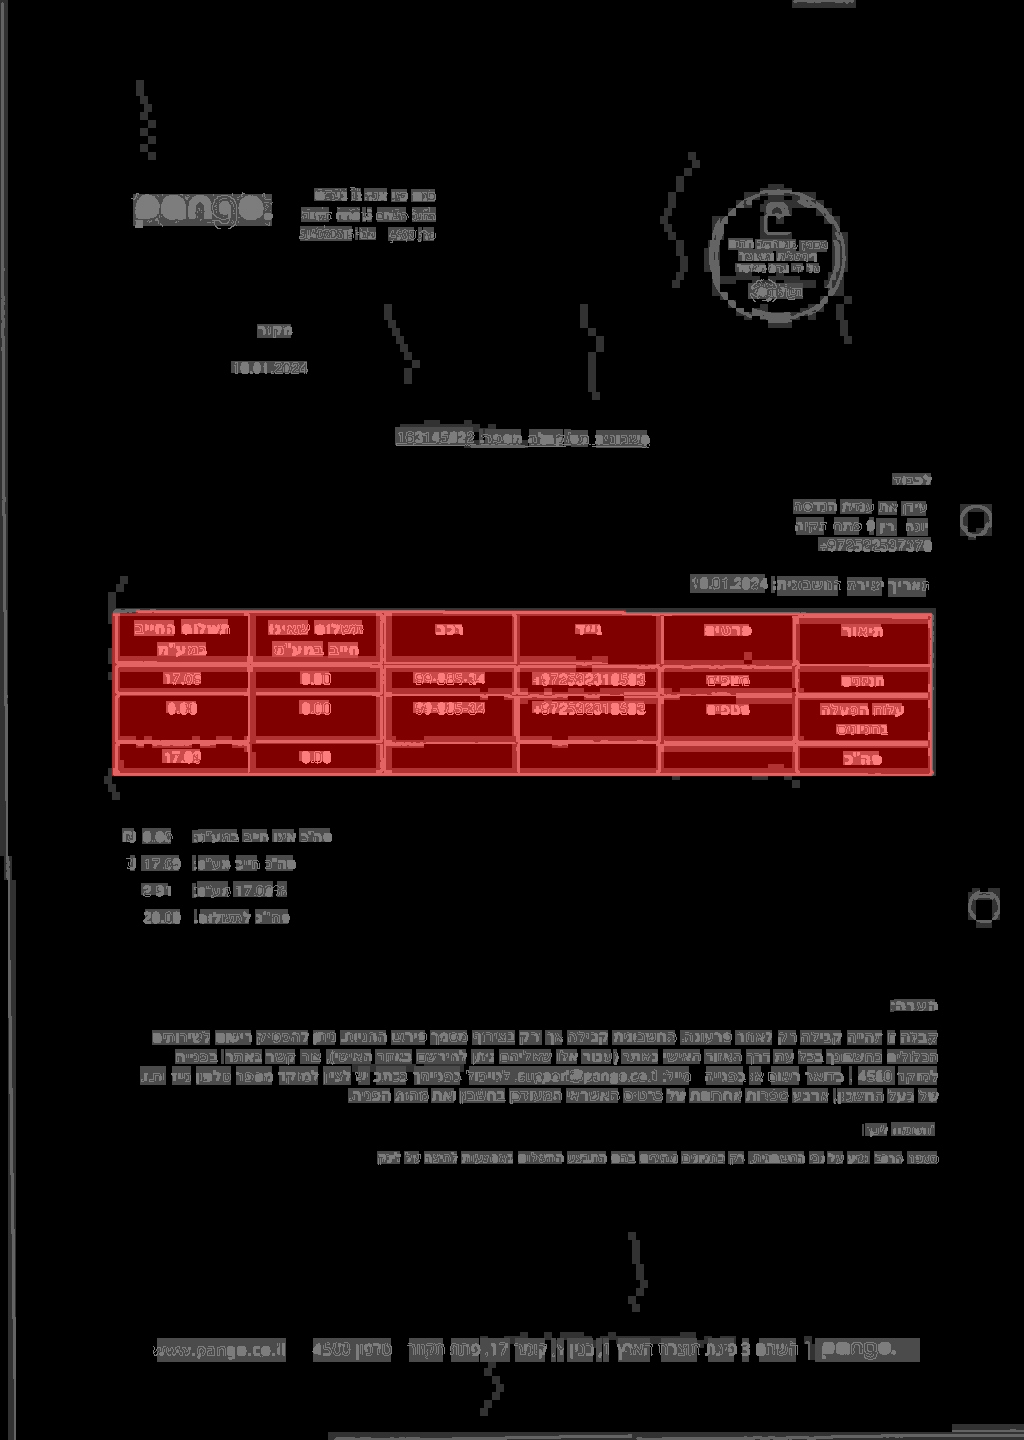

In [26]:
#Predict on a test image and overlay the mask on the original image
ds = train_ds
test_idx = 0
input_image_file = os.path.join(ds.root_dir,ds.images[test_idx])
input_image = Image.open(input_image_file)
test_batch = ds[test_idx]
images, masks = test_batch
images = torch.unsqueeze(images, 0)
masks = torch.unsqueeze(masks, 0)
images= images.to(DEVICE)
# outputs = model(images.half())
outputs = model(images)
preds = torch.sigmoid(outputs)
predicted_mask = (preds > 0.5).float()


mask = prediction_to_vis(predicted_mask[test_idx,:,:].cpu())
mask = mask.resize(input_image.size)
mask = mask.convert("RGBA")
input_image = input_image.convert("RGBA")
overlay_img = Image.blend(input_image, mask, 0.5)
overlay_img